## Installing and importing libraries

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import numpy as np # library to handle data in a vectorized manner
import pandas as pd

import types
from botocore.client import Config
import ibm_boto3

#!conda install -c conda-forge geopy --yes
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

print('Libraries imported')

Libraries imported


## For Sercurity reasons, the code for importing bikerack.csv has been hidden

In [3]:
df_BikeRacks.head()

,RackID,Address,Ward,Community Area,Community Name,TotInstall,Latitude,Longitude,Historical,F12,F13,LOCATION,Boundaries - ZIP Codes,Community Areas,Zip Codes,Census Tracts,Wards,Historical Wards 2003-2015
0,3492,1391 N Milwaukee Ave,1,24,West Town,1.0,41.907164,-87.672159,1.0,41.907164,-87.672159,"{'latitude': '41.907164', 'longitude': '-87.67...",4.0,25.0,21560,482.0,41.0,24.0
1,1284,1554 E 55th St,4,41,Hyde Park,1.0,41.795283,-87.587632,1.0,41.795283,-87.587632,"{'latitude': '41.795283', 'longitude': '-87.58...",10.0,8.0,21192,500.0,33.0,1.0
2,5945,1001 N Damen Ave,1,24,West Town,1.0,41.899661,-87.677036,1.0,41.899661,-87.677036,"{'latitude': '41.899661', 'longitude': '-87.67...",4.0,25.0,21560,462.0,11.0,24.0
3,3241,1932 W Lawrence Ave,47,4,Lincoln Square,2.0,41.968910,-87.677444,1.0,41.968910,-87.677444,"{'latitude': '41.96891', 'longitude': '-87.677...",15.0,6.0,22616,106.0,18.0,13.0
4,1349,2157 W 19th St,25,31,Lower West Side,1.0,41.855659,-87.679748,1.0,41.855659,-87.679748,"{'latitude': '41.855659', 'longitude': '-87.67...",43.0,33.0,14920,4.0,26.0,8.0


## Selecting the desired columns from the BikeRacks DataFrame

In [4]:
neighborhoods = df_BikeRacks[['Community Area', 'Community Name', 'Latitude', 'Longitude']]
neighborhoods.astype({'Latitude': 'int32', 'Longitude': 'int32'})
neighborhoods.head()

,Community Area,Community Name,Latitude,Longitude
0,24,West Town,41.907164,-87.672159
1,41,Hyde Park,41.795283,-87.587632
2,24,West Town,41.899661,-87.677036
3,4,Lincoln Square,41.968910,-87.677444
4,31,Lower West Side,41.855659,-87.679748


## Checking shape and for null values in the latitude and longitude columns

In [5]:
neighborhoods.shape

(5164, 4)

In [6]:
neighborhoods.Latitude.isnull().sum()

0

In [7]:
neighborhoods.Longitude.isnull().sum()

0

## Looking at the unique communities and number of bike racks

In [8]:
neighborhoods.groupby("Community Name").nunique()

,Community Area,Community Name,Latitude,Longitude
Community Name,,,,
Albany Park,1,1,55,57
Archer Heights,1,1,9,9
Armour Square,1,1,28,28
Ashburn,1,1,38,38
Auburn Gresham,1,1,28,28
Austin,1,1,90,93
Avalon Park,1,1,12,12
Avondale,1,1,30,30
Belmont Cragin,1,1,60,63


## Getting an average latitude and longitude for each Community Area

In [9]:
community_unique = neighborhoods.groupby("Community Name").mean().reset_index()
print(len(community_unique))
community_unique.head()

77


,Community Name,Community Area,Latitude,Longitude
0,Albany Park,14,41.966615,-87.719082
1,Archer Heights,57,41.803095,-87.725199
2,Armour Square,34,41.844592,-87.633735
3,Ashburn,70,41.745958,-87.706780
4,Auburn Gresham,71,41.747317,-87.657136


## Setting up FourSquare

In [10]:
CLIENT_ID = '*****' # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Set up of the Function to get the venues from FourSquare

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=800): #radius is in meters ~ set for just under a half-mile
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("No items found")
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    print(len(venues_list))
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("Query Complete")
    return(nearby_venues)

   


## The FourSquare Call

In [12]:
LIMIT = 10
radius = 800 #in meters ~ just under a half-mile from a known bike rack
community = getNearbyVenues(names=community_unique['Community Name'],
                                   latitudes=community_unique['Latitude'],
                                   longitudes=community_unique['Longitude'])


Albany Park
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Chatham
Chicago Lawn
Clearing
Douglas
Dunning
East Garfield Park
East Side
Edgewater
Edison Park
Englewood
Forest Glen
Fuller Park
Gage Park
Garfield Ridge
Grand Boulevard
Greater Grand Crossing
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Logan Square
Loop
Lower West Side
McKinley Park
Montclare
Morgan Park
Mount Greenwood
Near North Side
Near South Side
Near West Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Portage Park
Pullman
Riverdale
Rogers Park
Roseland
South Chicago
South Deering
South Lawndale
South Shore
Uptown
Washington Heights
Washington Park
West Elsdon
West Englewood
West Garfield Park
West Lawn
West Pullman
West Ridge
West Town
Woodlawn
77
Query Complete


## Inspecting the new community dataframe which contains venues for community areas

In [13]:
community.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany Park,41.966615,-87.719082,Chicago Kalbi Korean BBQ,41.968314,-87.722771,Korean Restaurant
1,Albany Park,41.966615,-87.719082,El Gallo Bravo #6,41.968324,-87.721338,Mexican Restaurant
2,Albany Park,41.966615,-87.719082,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,Albany Park,41.966615,-87.719082,Lawrence Fish Market,41.968280,-87.726250,Seafood Restaurant
4,Albany Park,41.966615,-87.719082,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant


In [14]:
print('There are {} uniques categories.'.format(len(community['Venue Category'].unique())))

There are 165 uniques categories.


## Setting up the encoding

In [15]:
# one hot encoding
chicago_onehot = pd.get_dummies(community[['Venue Category']], prefix="", prefix_sep="")
chicago_onehot.rename(columns={"Neighborhood": "Houses"})
# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = community['Neighborhood'] 
i = 0
for column in chicago_onehot.columns:
    if column == 'Neighborhood':
        break
    i += 1

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[i]] + list(chicago_onehot.columns[0:i]) + list(chicago_onehot.columns[i+1:len(community['Venue Category'].unique())])

chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
chicago_onehot.shape

(751, 166)

In [17]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Albany Park,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Archer Heights,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.1,0.0,0.0,0.0,0.0
2,Armour Square,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashburn,0.0,0.000,0.0,0.0,0.100,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Auburn Gresham,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.1,0.0,0.0,0.0
5,Austin,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,Avalon Park,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,Avondale,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,Belmont Cragin,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,Beverly,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Function for getting the top venues

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
##Check this code ~ find equalilant to toronto_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Chinese Restaurant,Grocery Store,Korean Restaurant,Sushi Restaurant,Cocktail Bar,Hot Dog Joint,Fried Chicken Joint,Seafood Restaurant,Mexican Restaurant,Donut Shop
1,Archer Heights,Bar,Mexican Restaurant,Bakery,Video Game Store,Pizza Place,Flea Market,Discount Store,Sandwich Place,Yoga Studio,Eye Doctor
2,Armour Square,Pizza Place,Chinese Restaurant,Cosmetics Shop,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Discount Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
3,Ashburn,Cosmetics Shop,Hot Dog Joint,Liquor Store,Italian Restaurant,Bank,Fast Food Restaurant,Automotive Shop,Light Rail Station,American Restaurant,Pizza Place
4,Auburn Gresham,Pharmacy,Bar,Greek Restaurant,Park,Discount Store,Lounge,Southern / Soul Food Restaurant,Fast Food Restaurant,Video Store,Garden Center


In [20]:
data_grouped = chicago_grouped.copy()
data_grouped.drop(['Neighborhood'], axis=1, inplace=True)
data_grouped.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0


## Deciding on the number of clusters

In [21]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_grouped)
    Sum_of_squared_distances.append(km.inertia_)

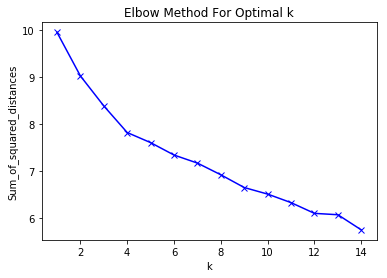

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Clustering the different neighborhoods into 4 different clusters

In [23]:
# set number of clusters
kclusters = 4

chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 3, 3, 0, 0, 0, 1, 1, 3, 3, 3, 0, 1, 0, 0, 3, 0, 3, 0, 1, 3,
       3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1,
       1, 0, 3, 3, 3, 3, 1, 3, 0, 3, 3, 0, 3, 3, 0, 2, 3, 0, 1, 3, 1, 3,
       3, 0, 0, 1, 0, 0, 1, 0, 3, 3, 3], dtype=int32)

## Adding Cluster Labels to the data

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = community_unique.copy()

# merge chicago_grouped with chicago_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Community Name')

chicago_merged.head() # check the last columns!

,Community Name,Community Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,14,41.966615,-87.719082,1,Chinese Restaurant,Grocery Store,Korean Restaurant,Sushi Restaurant,Cocktail Bar,Hot Dog Joint,Fried Chicken Joint,Seafood Restaurant,Mexican Restaurant,Donut Shop
1,Archer Heights,57,41.803095,-87.725199,1,Bar,Mexican Restaurant,Bakery,Video Game Store,Pizza Place,Flea Market,Discount Store,Sandwich Place,Yoga Studio,Eye Doctor
2,Armour Square,34,41.844592,-87.633735,3,Pizza Place,Chinese Restaurant,Cosmetics Shop,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Discount Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
3,Ashburn,70,41.745958,-87.706780,3,Cosmetics Shop,Hot Dog Joint,Liquor Store,Italian Restaurant,Bank,Fast Food Restaurant,Automotive Shop,Light Rail Station,American Restaurant,Pizza Place
4,Auburn Gresham,71,41.747317,-87.657136,0,Pharmacy,Bar,Greek Restaurant,Park,Discount Store,Lounge,Southern / Soul Food Restaurant,Fast Food Restaurant,Video Store,Garden Center


In [25]:
chicago_merged.groupby('Cluster Labels').count()

,Community Name,Community Area,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,19,19,19,19,19,19,19,19,19,19,19,19,19,19
1,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,39,39,39,39,39,39,39,39,39,39,39,39,39,39


## Creating a map of the clusters

In [26]:
#Chicago's Latitude and longitude
latitude = 41.8781
longitude = -87.6298

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community Name'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == 0:
        rainbow = 'red'
    elif cluster == 1:
        rainbow = 'blue'
    elif cluster == 2:
        rainbow = 'purple'
    elif cluster == 3:
        rainbow = 'orange'
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow,
        fill=True,
        #fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Calculating the number of bike racks per community area

In [27]:
num_BikeRacks = neighborhoods.groupby("Community Name").nunique()
num_BikeRacks['Bike Racks'] = num_BikeRacks[["Latitude", "Longitude"]].max(axis=1)
num_BikeRacks.drop(columns = ['Community Area', 'Community Name', 'Latitude', 'Longitude'], axis=1, inplace = True)
num_BikeRacks.reset_index(inplace=True)
num_BikeRacks.head()

,Community Name,Bike Racks
0,Albany Park,57
1,Archer Heights,9
2,Armour Square,28
3,Ashburn,38
4,Auburn Gresham,28


In [28]:
chicago = chicago_merged.copy()
chicago.shape

(77, 15)

## Adding the number of bike racks to the data

In [29]:
chicago = chicago.join(num_BikeRacks.set_index('Community Name'), on='Community Name')
chicago.dropna(axis=0, inplace=True)
chicago[['Cluster Labels']] = chicago[['Cluster Labels']].astype(int)

chicago.head()

,Community Name,Community Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Bike Racks
0,Albany Park,14,41.966615,-87.719082,1,Chinese Restaurant,Grocery Store,Korean Restaurant,Sushi Restaurant,Cocktail Bar,Hot Dog Joint,Fried Chicken Joint,Seafood Restaurant,Mexican Restaurant,Donut Shop,57
1,Archer Heights,57,41.803095,-87.725199,1,Bar,Mexican Restaurant,Bakery,Video Game Store,Pizza Place,Flea Market,Discount Store,Sandwich Place,Yoga Studio,Eye Doctor,9
2,Armour Square,34,41.844592,-87.633735,3,Pizza Place,Chinese Restaurant,Cosmetics Shop,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Discount Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,28
3,Ashburn,70,41.745958,-87.706780,3,Cosmetics Shop,Hot Dog Joint,Liquor Store,Italian Restaurant,Bank,Fast Food Restaurant,Automotive Shop,Light Rail Station,American Restaurant,Pizza Place,38
4,Auburn Gresham,71,41.747317,-87.657136,0,Pharmacy,Bar,Greek Restaurant,Park,Discount Store,Lounge,Southern / Soul Food Restaurant,Fast Food Restaurant,Video Store,Garden Center,28


## Just checking to make sure no data was lost

In [30]:
chicago.shape

(77, 16)

## Calculating average number of bike rack per cluster

In [31]:
cluster_bikeRacks = chicago.groupby(["Cluster Labels"])["Bike Racks"].mean()
cluster_bikeRacks

Cluster Labels
0    28.631579
1    43.944444
2     4.000000
3    83.743590
Name: Bike Racks, dtype: float64

## Bar Graph of Bike Racks per Cluster

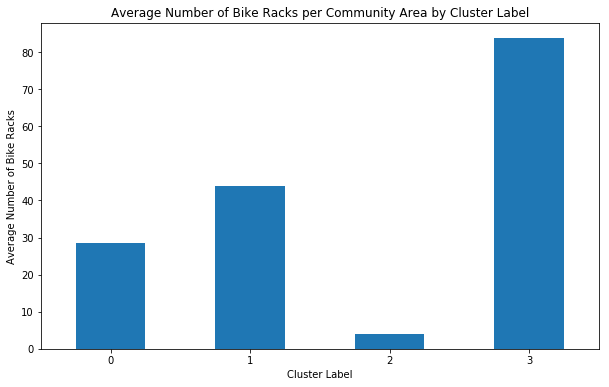

In [32]:
cluster_bikeRacks.plot(kind='bar', figsize=(10,6))
plt.xlabel('Cluster Label')
plt.xticks(rotation=0)
plt.ylabel('Average Number of Bike Racks')
plt.title('Average Number of Bike Racks per Community Area by Cluster Label')
plt.show()

## Making a list of venues per cluster

In [33]:
cluster_venues = []

for cluster in range(0,4):
    cluster_group = chicago.loc[chicago['Cluster Labels'] == cluster]
    cluster_group.drop(['Community Name', 'Community Area', 'Latitude', 'Longitude', 'Bike Racks'], axis=1, inplace=True)
    rows = len(cluster_group)

    venues = []
    for i in range (1,11):
        for row in range(0,rows):
            venues.append(cluster_group.iloc[row,i])
    cluster_venues.append(venues)
    


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
cluster_zero = pd.DataFrame(cluster_venues[0], columns=['Venue'])
cluster_zero['Venue Count'] = 1
cluster_one = pd.DataFrame(cluster_venues[1], columns=['Venue'])
cluster_one['Venue Count'] = 1
cluster_two = pd.DataFrame(cluster_venues[2], columns=['Venue'])
cluster_two['Venue Count'] = 1
cluster_three = pd.DataFrame(cluster_venues[3], columns=['Venue'])
cluster_three['Venue Count'] = 1

## Viewing top ten count of Venues per Cluster

In [35]:
cluster_zero_grouped = cluster_zero.groupby('Venue').sum()
cluster_zero_grouped.sort_values('Venue Count', ascending=False, inplace=True)
cluster_zero_grouped.head(10)

,Venue Count
Venue,
Fast Food Restaurant,10
Sandwich Place,9
Donut Shop,9
Discount Store,8
Fried Chicken Joint,8
Train Station,8
Park,6
Pharmacy,6
Cosmetics Shop,4


In [36]:
cluster_one_grouped = cluster_one.groupby('Venue').sum()
cluster_one_grouped.sort_values('Venue Count', ascending=False, inplace = True)
cluster_one_grouped.head(10)

,Venue Count
Venue,
Mexican Restaurant,18
Grocery Store,9
Discount Store,8
Pharmacy,8
Diner,8
Bar,6
Eye Doctor,5
Ice Cream Shop,5
Donut Shop,5


In [37]:
cluster_two_grouped = cluster_two.groupby('Venue').sum()
cluster_two_grouped.sort_values('Venue Count', ascending=False, inplace = True)
cluster_two_grouped.head(10)

,Venue Count
Venue,
Dive Bar,1
Donut Shop,1
Eastern European Restaurant,1
Electronics Store,1
Ethiopian Restaurant,1
Eye Doctor,1
Farm,1
Farmers Market,1
Park,1


In [38]:
cluster_three_grouped = cluster_three.groupby('Venue').sum()
cluster_three_grouped.sort_values('Venue Count', ascending=False, inplace = True)
cluster_three_grouped.head(10)

,Venue Count
Venue,
Pizza Place,23
Park,14
Coffee Shop,12
Bar,12
Italian Restaurant,9
Deli / Bodega,9
Yoga Studio,8
Breakfast Spot,8
Café,8


## Graphs for top ten Venues per Cluster

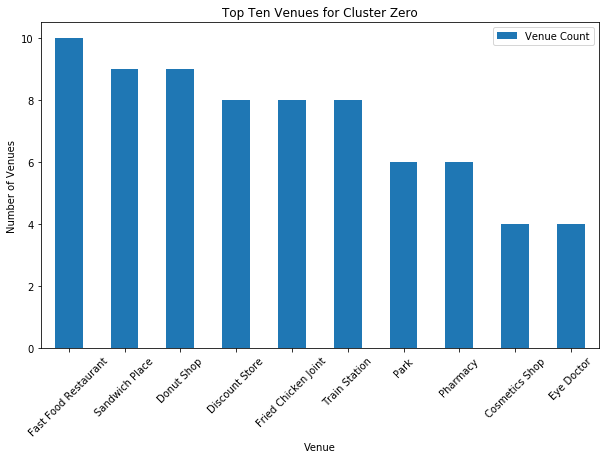

In [39]:
cluster_zero_grouped.head(10).plot(kind='bar', figsize=(10,6))
plt.xlabel('Venue')
plt.xticks(rotation=45)
plt.ylabel('Number of Venues')
plt.title('Top Ten Venues for Cluster Zero')
plt.show()

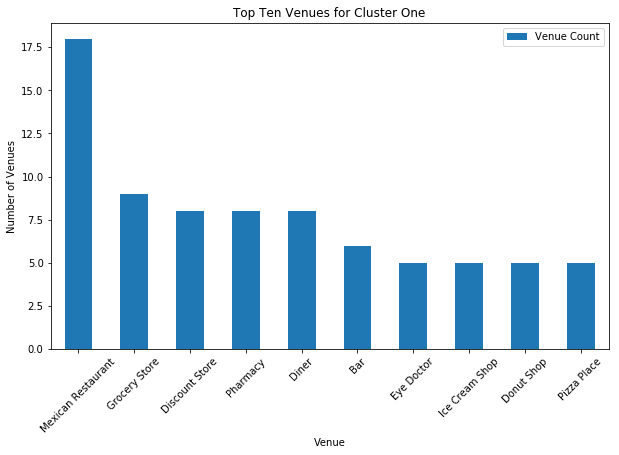

In [40]:
cluster_one_grouped.head(10).plot(kind='bar', figsize=(10,6))
plt.xlabel('Venue')
plt.xticks(rotation=45)
plt.ylabel('Number of Venues')
plt.title('Top Ten Venues for Cluster One')
plt.show()

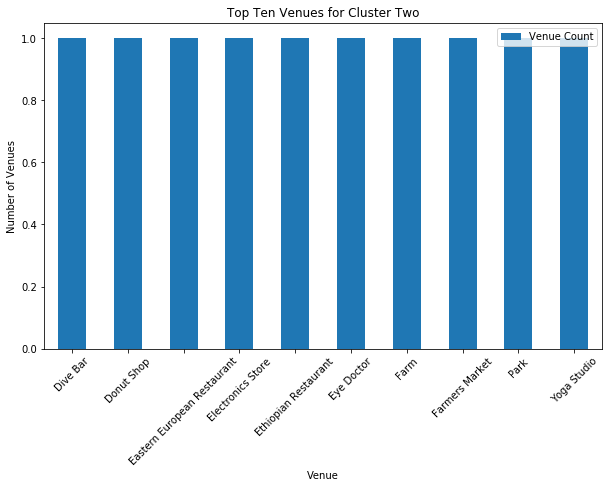

In [41]:
cluster_two_grouped.head(10).plot(kind='bar', figsize=(10,6))
plt.xlabel('Venue')
plt.xticks(rotation=45)
plt.ylabel('Number of Venues')
plt.title('Top Ten Venues for Cluster Two')
plt.show()

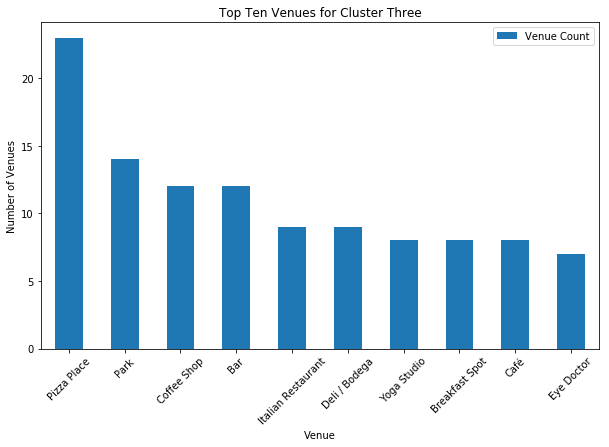

In [42]:
cluster_three_grouped.head(10).plot(kind='bar', figsize=(10,6))
plt.xlabel('Venue')
plt.xticks(rotation=45)
plt.ylabel('Number of Venues')
plt.title('Top Ten Venues for Cluster Three')
plt.show()

## Map of Cluster that I recommend

In [43]:
#Chicago's Latitude and longitude
latitude = 41.8781
longitude = -87.6298

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#cluster_group = chicago.loc[chicago['Cluster Labels'] == cluster]
chicago_merged_final = chicago_merged.loc[chicago_merged['Cluster Labels'] == 3]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged_final['Latitude'], chicago_merged_final['Longitude'], chicago_merged_final['Community Name'], chicago_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    rainbow = 'purple'
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## List of neighborhoods that would be appropriate for opening a restaurant

In [44]:
chicago_merged_final.reset_index(inplace=True)
print(chicago_merged_final['Community Name'])

0              Armour Square
1                    Ashburn
2                    Beverly
3                 Bridgeport
4              Brighton Park
5                   Clearing
6                    Dunning
7                  Edgewater
8                Edison Park
9                Forest Glen
10            Garfield Ridge
11           Grand Boulevard
12    Greater Grand Crossing
13                 Hegewisch
14             Humboldt Park
15                 Hyde Park
16               Irving Park
17            Jefferson Park
18                   Kenwood
19                 Lake View
20              Lincoln Park
21            Lincoln Square
22                      Loop
23           Mount Greenwood
24           Near North Side
25           Near South Side
26            Near West Side
27              North Center
28                North Park
29              Norwood Park
30                   Oakland
31              Portage Park
32               Rogers Park
33             South Deering
34            